In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

from sklearn import linear_model, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE


import warnings
warnings.filterwarnings("ignore")

In [3]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [4]:
# Load data
red_wines = pd.read_csv('RedWinesRatings.csv', index_col=0)
white_wines = pd.read_csv('WhiteWinesRatings.csv', index_col=0)

# Red wines regression

In [5]:
red_wines.head()

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
1,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,2
2,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,2
3,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,2
4,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,2
5,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,2


In [6]:
red_wines.shape

(1599, 12)

In [7]:
#target check
red_wines['quality'].unique()

array([2, 3, 1], dtype=int64)

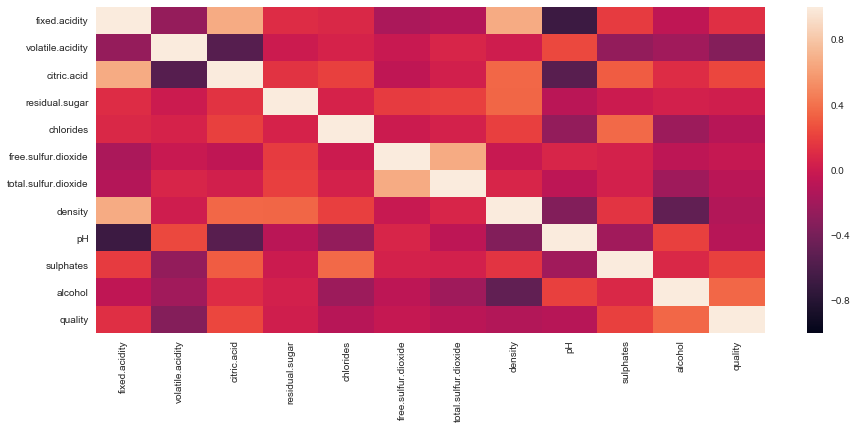

In [8]:
sns.heatmap(red_wines.corr(), vmin=-1, vmax=1)

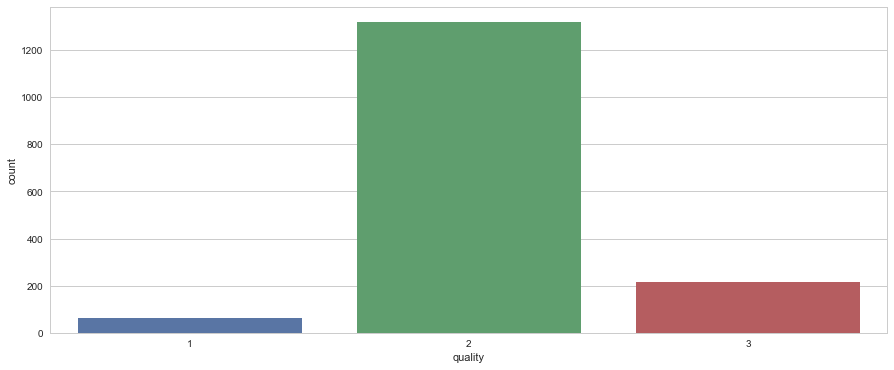

In [9]:
#check how the target looks like
sns.countplot(red_wines['quality']);

In [10]:
def scatter_features(df, feature_1, feature_2, target , dataset_name):
    df = df[[feature_1, feature_2, target]].copy()
    quality_one = df[df['quality']==1]
    quality_two = df[df['quality']==2]
    quality_three = df[df['quality']==3]

    plt.scatter(quality_one.iloc[:,0], quality_one.iloc[:,1], label='Quality 1')
    plt.scatter(quality_two.iloc[:,0], quality_two.iloc[:,1], label = 'Quality 2')
    plt.scatter(quality_three.iloc[:,0], quality_three.iloc[:,1], label = 'Quality 3')
    plt.title(dataset_name + ' - ' + feature_1 + ' + ' + feature_2)
    plt.xlabel(feature_1)
    plt.ylabel(feature_2)
    plt.legend();

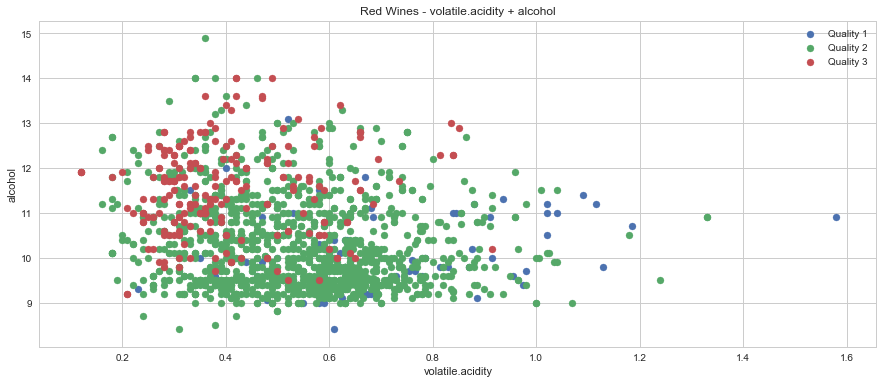

In [11]:
scatter_features(red_wines, 'volatile.acidity', 'alcohol', 'quality', 'Red Wines')

In [12]:
red_wines.groupby('quality').mean()

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol
quality,,,,,,,,,,,
1,7.871429,0.724206,0.173651,2.684921,0.095730,12.063492,34.444444,0.996689,3.384127,0.592222,10.215873
2,8.254284,0.538560,0.258264,2.503867,0.088973,16.368461,48.946929,0.996867,3.311296,0.647263,10.252717
3,8.847005,0.405530,0.376498,2.708756,0.075912,13.981567,34.889401,0.996030,3.288802,0.743456,11.518049


In [13]:
red_wines.describe()

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,2.096310
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.407354
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,1.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,2.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,2.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,2.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,3.000000


In [14]:
# first-look conclusions
    # quality increases while volatile acidity decreases
    # quality increases while citric acid increasess
    # quality increases while chlorides decreases
    # free sulfur dioxide has somehow a normal distribution relative to quality
    # quality increases while density decreases
    # quality increases while ph decreases
    # quality increases while sulfates increases
    # quality increases while alchool increases

In [15]:
def logistic_regression(df, C_param_range, solver, smote=False, feature_scalling = False, train_size = 0.7):
    
    X = df.iloc[:,:-1]
    y = df.iloc[:,-1]
    
    if feature_scalling:
        columns = X.columns
        scaler = StandardScaler()
        scaled_df = scaler.fit_transform(X)
        scaled_df = pd.DataFrame(scaled_df, columns=columns)
    
    if smote:
        os = SMOTE(random_state=0)
        X, y = os.fit_resample(X, y)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size)
    
    comparison = pd.DataFrame()
    
    for c in C_param_range:
        
        # Ovr (one over the rest)
        ovr_model = linear_model.LogisticRegression(multi_class='ovr', solver=solver, C=c).fit(X_train, y_train)

        # Multinomial 
        mul_model = linear_model.LogisticRegression(multi_class='multinomial', solver=solver, C=c).fit(X_train, y_train)
        
        comparison.loc[c,'OVR-LR Train Acc'] = metrics.accuracy_score(y_train, ovr_model.predict(X_train))
        comparison.loc[c,'OVR-LR Test Acc'] = metrics.accuracy_score(y_test, ovr_model.predict(X_test))
        comparison.loc[c,'MUL-LR Train Acc'] = metrics.accuracy_score(y_train, mul_model.predict(X_train))
        comparison.loc[c,'MUL-LR Test Acc'] = metrics.accuracy_score(y_test, mul_model.predict(X_test))
    
    
    comparison.index.name = 'C-value'
    
    return comparison

In [16]:
# No transformation
logistic_regression(red_wines, [0.001,0.01,0.1,1,10,100],'newton-cg')

,OVR-LR Train Acc,OVR-LR Test Acc,MUL-LR Train Acc,MUL-LR Test Acc
C-value,,,,
0.001,0.824844,0.825000,0.824844,0.825000
0.010,0.823056,0.825000,0.821269,0.829167
0.100,0.826631,0.837500,0.831993,0.845833
1.000,0.838248,0.847917,0.841823,0.845833
10.000,0.839142,0.847917,0.842717,0.843750
100.000,0.840929,0.843750,0.842717,0.843750


In [17]:
# Standardized data
logistic_regression(red_wines, [0.001,0.01,0.1,1,10,100],'newton-cg', feature_scalling=True)

,OVR-LR Train Acc,OVR-LR Test Acc,MUL-LR Train Acc,MUL-LR Test Acc
C-value,,,,
0.001,0.821269,0.833333,0.821269,0.833333
0.010,0.821269,0.833333,0.821269,0.829167
0.100,0.838248,0.825000,0.834674,0.822917
1.000,0.842717,0.835417,0.843610,0.835417
10.000,0.843610,0.837500,0.845398,0.831250
100.000,0.845398,0.837500,0.848972,0.833333


In [18]:
# Over-sampled data
logistic_regression(red_wines, [0.001,0.01,0.1,1,10,100],'newton-cg', smote=True)

,OVR-LR Train Acc,OVR-LR Test Acc,MUL-LR Train Acc,MUL-LR Test Acc
C-value,,,,
0.001,0.615385,0.590909,0.628386,0.609428
0.010,0.656916,0.647306,0.665583,0.654882
0.100,0.704225,0.696970,0.710726,0.696970
1.000,0.725894,0.708754,0.725533,0.705387
10.000,0.728061,0.708754,0.726616,0.703704
100.000,0.726977,0.711279,0.730228,0.706229


In [19]:
# Classification report example

X = red_wines.iloc[:,:-1]
y = red_wines.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)
# Ovr (one over the rest)
ovr_model = linear_model.LogisticRegression(multi_class='ovr', solver='newton-cg').fit(X_train, y_train)

print('OVR LR Test Acc.: ', metrics.accuracy_score(y_test, ovr_model.predict(X_test)), '\n')

print(classification_report(y_test, ovr_model.predict(X_test)))

OVR LR Test Acc.:  0.8395833333333333 

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        18
           2       0.86      0.97      0.91       397
           3       0.59      0.26      0.36        65

    accuracy                           0.84       480
   macro avg       0.48      0.41      0.42       480
weighted avg       0.79      0.84      0.80       480



* Precision = true_positive / (true positive + false positive)
* recall = true_positive / (true positive + false negative)
* F score  - weigthed harmonic mean of precision and recall (best value at 1, worst value at 0)
* support - number records for each class

### Conclusion for red_wines dataset
    * Average accuracy for ovr and multinomial models. However, accuracy is not stable (+/- 2%)
    * predominant class (2) has a good accuracy
    * classes 1 and 3 have very poor and poor accuracy, most probably due to reduced records compared to the predominant class
    * Over-sampling, stadardization are not improving the overall accuracy
    * C hyperparameter tunning not improving to much the overall accuracy

# White Wines  Logistic Regression

In [20]:
white_wines.head()

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
1,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,2
2,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,2
3,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,2
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,2
5,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,2


In [21]:
white_wines.shape

(4898, 12)

In [22]:
white_wines['quality'].unique()

array([2, 1, 3], dtype=int64)

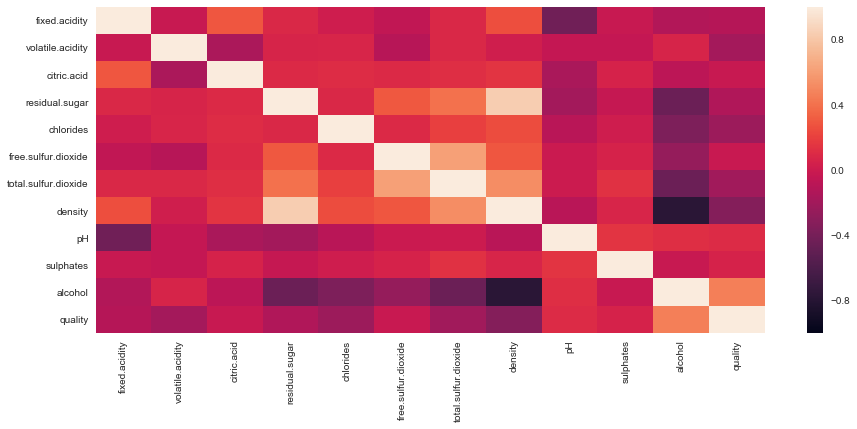

In [23]:
sns.heatmap(white_wines.corr(), vmin=-1, vmax=1)

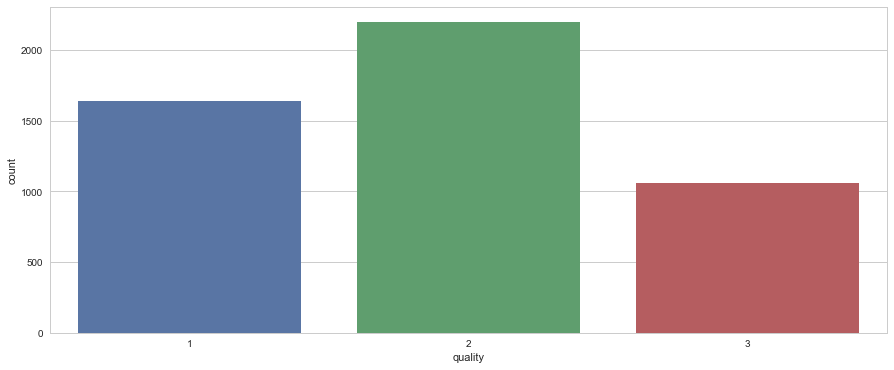

In [24]:
sns.countplot(white_wines['quality']);

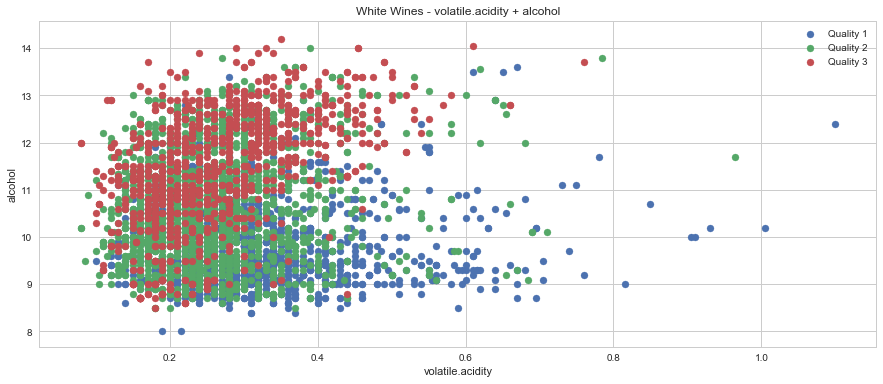

In [25]:
# Data visualization for 2 features
scatter_features(white_wines, 'volatile.acidity', 'alcohol', 'quality', 'White Wines')

In [26]:
white_wines.groupby('quality').mean()

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol
quality,,,,,,,,,,,
1,6.961524,0.310265,0.334311,7.054451,0.051436,35.338720,148.597866,0.995160,3.170457,0.481506,9.849530
2,6.837671,0.260564,0.338025,6.441606,0.045217,35.650591,137.047316,0.993961,3.188599,0.491106,10.575372
3,6.725142,0.265349,0.326057,5.261509,0.038160,34.550472,125.245283,0.992412,3.215132,0.500142,11.416022


In [27]:
white_wines.describe()

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,1.881584
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.733030
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,1.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,1.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,2.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,2.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,3.000000


In [28]:
# first-look conclusions
    # quality increases while fixed acidity decreases
    # quality increases while volatile acidity decreases
    # quality increases while chlorides decreases
    # free sulfur dioxide has somehow a normal distribution relative to quality
    # quality increases while total sulfur dioxide decreases
    # quality increases while density decreases
    # quality increases while ph increases
    # quality increases while sulfates increases
    # quality increases while alchool increases

In [29]:
logistic_regression(white_wines, [0.001,0.01,0.1,1,10,100],'newton-cg')

,OVR-LR Train Acc,OVR-LR Test Acc,MUL-LR Train Acc,MUL-LR Test Acc
C-value,,,,
0.001,0.497666,0.539456,0.509918,0.534694
0.010,0.545799,0.552381,0.545216,0.542857
0.100,0.565636,0.561905,0.564469,0.561905
1.000,0.568845,0.561905,0.573512,0.559864
10.000,0.572637,0.556463,0.571762,0.557823
100.000,0.574679,0.559184,0.572637,0.559864


In [30]:
logistic_regression(white_wines, [0.001,0.01,0.1,1,10,100],'newton-cg', feature_scalling=True)

,OVR-LR Train Acc,OVR-LR Test Acc,MUL-LR Train Acc,MUL-LR Test Acc
C-value,,,,
0.001,0.493291,0.497279,0.508168,0.515646
0.010,0.541424,0.546259,0.544341,0.539456
0.100,0.562135,0.569388,0.563594,0.570748
1.000,0.567970,0.580272,0.568261,0.571429
10.000,0.569428,0.581633,0.570303,0.573469
100.000,0.570012,0.578231,0.572054,0.572789


In [31]:
logistic_regression(white_wines, [0.001,0.01,0.1,1,10,100],'newton-cg', smote=True)

,OVR-LR Train Acc,OVR-LR Test Acc,MUL-LR Train Acc,MUL-LR Test Acc
C-value,,,,
0.001,0.549729,0.530066,0.559047,0.540677
0.010,0.558613,0.541182,0.558180,0.534108
0.100,0.566847,0.554826,0.571614,0.556847
1.000,0.582232,0.558363,0.577248,0.552299
10.000,0.581365,0.557858,0.583532,0.556342
100.000,0.587866,0.557352,0.585915,0.555836


In [32]:
# Classification report example

X = white_wines.iloc[:,:-1]
y = white_wines.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)
# Ovr (one over the rest)
ovr_model = linear_model.LogisticRegression(multi_class='ovr', solver='newton-cg').fit(X_train, y_train)

print('OVR LR Test Acc.: ', metrics.accuracy_score(y_test, ovr_model.predict(X_test)), '\n')

print(classification_report(y_test, ovr_model.predict(X_test)))

OVR LR Test Acc.:  0.5741496598639456 

              precision    recall  f1-score   support

           1       0.68      0.58      0.62       500
           2       0.52      0.71      0.60       648
           3       0.58      0.29      0.39       322

    accuracy                           0.57      1470
   macro avg       0.59      0.53      0.54      1470
weighted avg       0.59      0.57      0.56      1470



### Conclusion for white_wines dataset
    * Poor to average accuracy for ovr and multinomial models. Also, accuracy is not stable (+/- 2%)
    * Over-sampling, stadardization are not improving the overall accuracy
    * C hyperparameter tunning not improving to much the overall accuracy
    * All thre classes have similar precisions

# Conclusion
    * See conclusions for each dataset
    
    
    * Logistic regression is a friendly uncomplicated linear classifier, but for complex datasets is not performing well